# BENCHMARKING

The goal of this notebooks is to understand how **fantasyfootball** projections compare to a (1) naive benchmark, and (2) a subscription-based, "industry-grade" projection. Naive projections are a one-week lag of points scored by each player from the previous or last active week. The "industry-grade" projections are from a subscription-based fantasy sports website (www.fantasydata.com). 

Projection accuracy was assessed for the 2020 and 2021 seasons, starting with week three and ending with week 16, for a total of 28 games. The final game of each season is excluded from the training and evaluation of the projection model. Commonly, teams that have secured a place in the playoffs will reduce the workloads of their best players to prevent injury or fatigue. The absence of these players adds additional noise to the model, thereby reducing accuracy. Additionally, many fantasy football leagues end the season before the final game for this exact reason. 

The Mean Absolute Error (MAE) quantified projection performance. The forecasting horizon was one week ahead, and the Yahoo scoring system determined point projections for each player. Separate models were fit for each position (QB, RB, WR, TE). Projection performance was considered only for "active" players for the week and excluded all injured or ineligible players.


In [1]:
from itertools import product
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
import pandas_flavor as pf
import xgboost as xgb
from janitor import get_features_targets
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from fantasyfootball.config import root_dir, scoring
from fantasyfootball.data import FantasyData
from fantasyfootball.features import FantasyFeatures

In [2]:
@pf.register_dataframe_method
def filter_to_prior_week(
    df: pd.DataFrame, season_year: int, week_number: int
) -> pd.DataFrame:
    """Filter all data up until the most recently
       completed week.


    Args:
        df (pd.DataFrame): Historical data and features.
        season_year (int): Year of the season.
        week_number (int): Week number of the most recently completed week.

    Returns:
        pd.DataFrame: Historical data and features.
    """
    calendar_df = pd.read_csv(
        root_dir / "datasets" / "season" / str(season_year) / "calendar.gz"
    )
    prior_week_df = calendar_df[calendar_df["week"] == week_number]
    max_date_week = max(prior_week_df["date"])
    prior_week_df = df[df["date"] <= max_date_week]
    return prior_week_df

@pf.register_dataframe_method
def score_benchmark_data(benchmark_df: pd.DataFrame, scoring_source: str) -> pd.DataFrame:
    """Add point projection based on predictions from: https://fantasydata.com/nfl/fantasy-football-weekly-projections
       for use in benchmarking.

    Args:
        benchmark_df (pd.DataFrame): Weekly player predcitions from fantasydata.com.
        scoring_source (str): Name of the scoring system to apply (e.g., 'yahoo').

    Returns:
        pd.DataFrame: Weekly player predictions from fantasydata converted to scoring system. 

    """
    score_player = FantasyData.score_player
    # map different name spellings between
    scoring_source_rules = scoring.get(scoring_source)
    # score all players for that week
    scoring_columns = set(scoring_source_rules["scoring_columns"].keys()) & set(
        benchmark_df.columns
    )
    weekly_benchmark_preds = pd.DataFrame()
    for row in (
        benchmark_df[["name", "team", "position", "season_year"]]
        .drop_duplicates()
        .itertuples(index=False)
    ):
        player_df = benchmark_df[
            (benchmark_df["name"] == row.name)
            & (benchmark_df["team"] == row.team)
            & (benchmark_df["position"] == row.position)
            & (benchmark_df["season_year"] == row.season_year)
        ]
        player_weekly_points = score_player(
            player_df, scoring_columns, scoring_source_rules
        )
        player_df = player_df.assign(
            **{f"ff_pts_{scoring_source}_fantasydata_pred": player_weekly_points}
        )
        player_df = player_df[
            ["name", "team", "position", "season_year" ,"week", player_df.columns.tolist()[-1]]
        ]
        weekly_benchmark_preds = pd.concat([weekly_benchmark_preds, player_df])
    return  weekly_benchmark_preds   


def get_benchmarking_data(season_year_start: int, season_year_end: int, 
    base_url: str = "https://raw.githubusercontent.com/thecodeforest/fantasyfootball/main/examples/benchmarking_data/season/"
    ):
    all_benchmark_df = pd.DataFrame()
    for week, year in product(range(1, 18),range(season_year_start, season_year_end + 1)):
        benchmark_url = f"{base_url}/{year}/wk{week}.csv"
        benchmark_df = pd.read_csv(benchmark_url)
        benchmark_df['season_year'] = year
        all_benchmark_df = pd.concat([all_benchmark_df, benchmark_df])
    return all_benchmark_df    

In [3]:
# read in data foar all positions for 2015 - 2021 seasons
scoring_source = "yahoo"
fantasy_data = FantasyData(season_year_start=2015, season_year_end=2021)
fantasy_data.create_fantasy_points_column(scoring_source=scoring_source)    
benchmark_df = get_benchmarking_data(season_year_start = 2020, season_year_end = 2021)
benchmark_df = benchmark_df.score_benchmark_data(yvar=yvar, scoring_source=scoring_source)

Loading data from 2015 to 2021
Player injury data not available prior to 2016 season
Dropping final week (week 17) of season 2015
Dropping final week (week 17) of season 2016
Dropping final week (week 17) of season 2017
Dropping final week (week 17) of season 2018
Dropping final week (week 17) of season 2019
Dropping final week (week 17) of season 2020
Dropping final week (week 18) of season 2021


In [5]:
# extract the dataset and the name of our outcome variable (yvar)
fantasy_df = fantasy_data.data
yvar = fantasy_df.columns[-1]

In [6]:
# peak at a few observations
fantasy_df.tail()

,date,week,team,opp,is_away,season_year,name,position,pid,is_active,...,avg_windspeed,max_snow_depth,total_precip,avg_temp,injury_type,has_dnp_tag,has_limited_tag,most_recent_injury_status,n_injuries,ff_pts_yahoo
52191,2022-01-02,17,BAL,LAR,0,2021,Tylan Wallace,WR,WallTy00,1.0,...,30.4232,0.0,0.244095,56.48,no injury,0.0,0.0,no injury,0.0,0.0
52192,2022-01-02,17,BAL,LAR,0,2021,Miles Boykin,WR,BoykMi00,0.0,...,30.4232,0.0,0.244095,56.48,no injury,0.0,0.0,no injury,0.0,0.0
52193,2022-01-02,17,BAL,LAR,0,2021,Eric Tomlinson,TE,TomlEr01,1.0,...,30.4232,0.0,0.244095,56.48,no injury,0.0,0.0,no injury,0.0,0.0
52194,2022-01-02,17,BAL,LAR,0,2021,Nick Boyle,TE,BoylNi00,1.0,...,30.4232,0.0,0.244095,56.48,not injury related - resting player,1.0,0.0,DNP,1.0,0.7
52195,2022-01-02,17,BAL,LAR,0,2021,Nate McCrary,RB,McCrNa00,0.0,...,30.4232,0.0,0.244095,56.48,no injury,0.0,0.0,no injury,0.0,0.0


### Projection Performance 

In [7]:
# forecasting parameters
player_positions = ["QB","RB", "WR", "TE"]
test_season_years = [2020, 2021]
test_season_weeks = list(range(2, 17))
# columns common to all prediction sources
keys = ["season_year", "week", "name", "team","position","pid"]

# columns to use for each position as features. 
# Note that raw features are not transformed in any way.
input_features = {
    "QB": {
        "raw_features": ["draftkings_salary", "avg_windspeed", "avg_temp"],
        "position_features": ["passing_cmp"],
    },
    "RB": {
        "raw_features": ["draftkings_salary", "fanduel_salary"],
        "position_features": ["rushing_yds"],
    },
    "WR": {
        "raw_features": ["draftkings_salary", "has_dnp_tag"],
        "position_features": ["receiving_rec"],
    },
    "TE": {
        "raw_features": ["draftkings_salary", "fanduel_salary"],
        "position_features": ["receiving_rec"],
    },
} 

In [70]:
%%capture
benchmarking_results_df = pd.DataFrame()
for season_year, season_week in tqdm(
    list(product(test_season_years, test_season_weeks))
):
    if (season_week + 1) > max(test_season_weeks):
        continue
    for position in player_positions:
        # select all data prior to the week you want to create predictions for
        backtest_df = fantasy_df.filter_to_prior_week(
            season_year=season_year, week_number=season_week
        )
        #
        fantasy_features = FantasyFeatures(backtest_df, y=yvar, position=position)
        benchmark_df_preds = benchmark_df.query(f"(position == '{position}') & (season_year == {season_year}) & (week == {season_week + 1})")
        # prep data for prediction
        fantasy_features.log_transform_y()
        fantasy_features.filter_inactive_games(status_column="is_active")
        fantasy_features.create_future_week()
        fantasy_features.filter_n_games_played_by_season(min_games_played=2)
        fantasy_features.add_lag_feature(
            n_week_lag=1,
            lag_columns=[yvar] + input_features.get(position).get("position_features"),
        )
        fantasy_features.add_moving_avg_feature(
            n_week_window=4,
            window_columns=[yvar]
            + input_features.get(position).get("position_features"),
        )
        # extract new features and transformed feat
        derived_features, feature_df = fantasy_features.create_ff_signature()
        # filter to "train" (past week) from "test" (future week)
        hist_df = feature_df[feature_df["is_future_week"] == 0]
        future_df = feature_df[feature_df["is_future_week"] == 1]
        #
        all_features = (
            input_features.get(position).get("raw_features") + derived_features
        )
        # split historical X and y
        X_hist, y_hist = hist_df[all_features + [yvar]].get_features_targets(
            yvar, all_features
        )
        # get future X
        X_future = future_df[all_features]
        xgb_reg = xgb.XGBRegressor(
            max_depth=3,
            n_estimators=500,
            n_jobs=4,
            learning_rate=0.01,
            colsample_bytree=0.6,
            subsample=0.7,
            eval_metric=mean_absolute_error,
            booster="gbtree",
            random_state=2022,
        )
        xgb_reg.fit(X_hist.values, y_hist.values)
        xgb_y_future = xgb_reg.predict(X_future.values)
        # assign projections
        future_df = future_df.assign(**{f"{yvar}_ff_pred": xgb_y_future})
        # invert log transform
        future_df[f"{yvar}_ff_pred"] = future_df[f"{yvar}_ff_pred"].transform(
            lambda x: np.expm1(x)
        )
        # naive lag 1 projection (predict points player scored in last active game)
        naive_pred_df = hist_df[keys + [yvar]].query(
            f"season_year=={season_year} & week == {season_week}"
        )
        naive_pred_df = naive_pred_df.rename(columns={yvar: f"{yvar}_naive_pred"})
        naive_pred_df["week"] = naive_pred_df["week"] + 1
        naive_pred_df[f"{yvar}_naive_pred"] = naive_pred_df[f"{yvar}_naive_pred"].transform(
            lambda x: np.expm1(x)
        )
        # actuals
        actuals_df = fantasy_df.query(
            f"season_year == {season_year} & week == {season_week + 1} & is_active == 1"
        )
        # merge fantasyfootball package projections
        weekly_pred_results_df = pd.merge(
            actuals_df[keys + [yvar]],
            future_df[keys + [f"{yvar}_ff_pred"]],
            on=keys,
            how="inner",
        )

        # merge fantasydata projections
        weekly_pred_results_df = pd.merge(
            weekly_pred_results_df,
            benchmark_df_preds,
            on=["season_year","name", "team", "position", "week"],
            how="inner",
        )
        # merge naive predictions
        weekly_pred_results_df = pd.merge(
            weekly_pred_results_df, naive_pred_df, on=keys, how="inner"
        )
        benchmarking_results_df = pd.concat(
            [benchmarking_results_df, weekly_pred_results_df]
        )

In [71]:
benchmarking_results_df.head()

,season_year,week,name,team,position,pid,ff_pts_yahoo,ff_pts_yahoo_ff_pred,ff_pts_yahoo_fantasydata_pred,ff_pts_yahoo_naive_pred
0,2020,3,Deshaun Watson,HOU,QB,WatsDe00,18.06,19.322643,19.122,15.70
1,2020,3,Joe Burrow,CIN,QB,BurrJo01,20.48,17.085040,18.492,22.54
2,2020,3,Carson Wentz,PHI,QB,WentCa00,21.5,13.999765,19.478,14.38
3,2020,3,Ryan Fitzpatrick,MIA,QB,FitzRy00,24.7,9.784729,18.442,22.32
4,2020,3,Kirk Cousins,MIN,QB,CousKi00,21.44,8.079314,16.668,1.52


In [72]:
# calculate absolute error for each prediction source
truth = benchmarking_results_df[yvar]
for pred_column in [
    x for x in benchmarking_results_df.columns.tolist() if x.endswith("_pred")
]:
    abs_error = abs(truth - benchmarking_results_df[pred_column])
    benchmarking_results_df[f"{pred_column}_abs_error"] = abs_error

In [73]:
# select position and error columns
error_columns = [x for x in benchmarking_results_df.columns if x.endswith("_abs_error")]
benchmarking_results_df = benchmarking_results_df[["position"] + error_columns]

In [74]:
# calculate error across all positions
global_avg_error = benchmarking_results_df[error_columns].mean().round(1).to_frame()
print(global_avg_error)

                                           0
ff_pts_yahoo_ff_pred_abs_error           4.6
ff_pts_yahoo_fantasydata_pred_abs_error  4.4
ff_pts_yahoo_naive_pred_abs_error        5.6


In [75]:
position_avg_error = pd.melt(
    benchmarking_results_df, id_vars=["position"], value_vars=error_columns
)
position_avg_error = position_avg_error.groupby(["position", "variable"]).agg(["mean"])
position_avg_error = position_avg_error.droplevel(0, axis=1).reset_index()
position_avg_error["mean"] = position_avg_error["mean"].round(1)

<Figure size 1440x720 with 0 Axes>

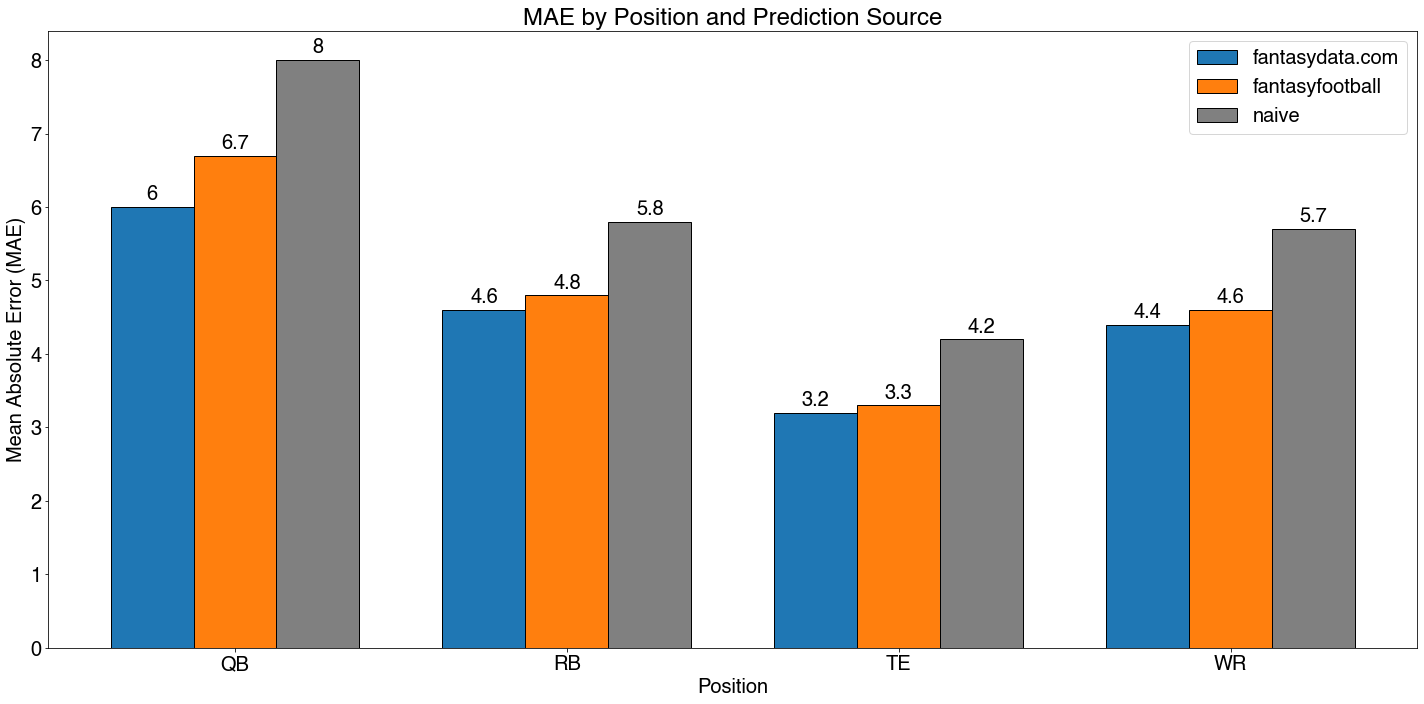

<Figure size 1440x720 with 0 Axes>

In [76]:
# plot MAE by position
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc("figure", facecolor="white")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure(facecolor="white")

bar_width = 0.25
 
# set heights of bars
positions = position_avg_error["position"].unique().tolist()
labels = ["QB", "RB", "TE", "WR"]
x = np.arange(len(positions))
y1 = position_avg_error.query("variable == 'ff_pts_yahoo_fantasydata_pred_abs_error'")[
    "mean"
]
y2 = position_avg_error.query("variable == 'ff_pts_yahoo_ff_pred_abs_error'")["mean"]
y3 = position_avg_error.query("variable == 'ff_pts_yahoo_naive_pred_abs_error'")["mean"]


fig, ax = plt.subplots()
rects1 = ax.bar(
    x - bar_width, y1, bar_width, label="fantasydata.com", edgecolor="black"
)
rects2 = ax.bar(x, y2, bar_width, label="fantasyfootball", edgecolor="black")
rects3 = ax.bar(
    x + bar_width, y3, bar_width, label="naive", color="gray", edgecolor="black"
)

ax.set_ylabel('Mean Absolute Error (MAE)')
ax.set_title('MAE by Position and Prediction Source')
ax.set_xlabel('Position')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout(pad=0.75)
plt.figure(facecolor="white")
plt.show()